In [1]:
%matplotlib notebook
import numpy as np 
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt

/home/uvishal1995/.local/lib/python2.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'nbAgg' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/uvishal1995/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/uvishal1995/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/uvishal1995/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/uvishal1

In [2]:
from Traveller import two_opt as Reorganize
import cv2

In [3]:
from skimage.filters import threshold_otsu as Otsu
import matplotlib.animation as animation

### Making epicyclic diagrams

Can we approximate a given function using fourier series? This is basically done in the notebook.
Feed in an appropriate image, get the outline (needs a continuous set of points!) and get a fourier approximation using epicycles!

My reference: https://mathematica.stackexchange.com/a/171756 (this is amazing, and much neater than mine; though done mathematica).

Requirements: Need a silhouette image; there should be a continuous closed loop as our figure at the end, we cannot have multiple edges. For reference, check the images in the [assets](assets/) folder.


In [54]:
'''
    Image preprocessing. The flow ideally would be:
    Image->Grayscale()->Threshold->Obtain edges->Clean edges. This varies from image to image, and person to person.
'''
img = cv2.GaussianBlur(cv2.cvtColor(cv2.imread('assets/A2.png'),cv2.COLOR_BGR2GRAY),(1,1),0)
#img2 = img[:450,:]
kernel = np.ones((5,5),np.uint8)
#img2 = img
img2=cv2.dilate(img,kernel,iterations = 30)
print img2.shape

(7579, 7416)


In [55]:
val = Otsu(img2)
img2=img2>val
img2=cv2.resize(img2.astype(np.float32),(100,100))
img2 = cv2.Laplacian(img2.astype(np.float32),cv2.CV_32F)
img2=img2>np.mean(img2)
img2 = img2.astype(np.float32)
plt.imshow(img2,cmap='gray')

In [56]:
print np.max(img2)
print np.min(img2)

1.0
0.0


In [57]:
coords = np.where(img2!=np.min(img2))
coords = np.asarray(coords)
coords = np.hstack((np.reshape(coords[1,:],[-1,1]),np.reshape(np.max(coords[0,:])-coords[0,:],[-1,1])))
print coords.shape

(607, 2)


<IPython.core.display.Javascript object>


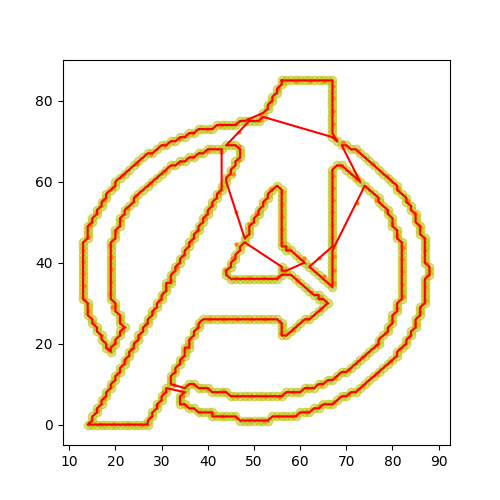

In [58]:
plt.figure(figsize=(5,5))
#plt.scatter(coords[1,:],np.max(coords[0,:])-coords[0,:])
plt.scatter(coords[:,0],coords[:,1],s=1.0)
#plt.plot(coords[:,0],coords[:,1],'g')

Next up, we have a list of coordinates. Now, we will need to sort them to obtain a continuous sequence of points. For this purpose, the 2-opt algorithm for the 'travelling salesman proble' is used: https://en.wikipedia.org/wiki/2-opt

In [59]:
route=Reorganize(coords,0.01)

In [60]:
new_cities_order = np.concatenate((np.array([coords[route[i]] for i in range(len(route))]),np.array([coords[0]])))
plt.scatter(coords[:,0],coords[:,1],color='y',alpha=0.5)
plt.plot(new_cities_order[:,0],new_cities_order[:,1],'r')

Conver the obtained coordinates into complex numbers, i.e: (x,y) --> x+iy

In [61]:
CoordList = new_cities_order[:,0]+1j*new_cities_order[:,1]

Perform fourier transform and obtain the coefficients. This can be done using np.fft.fft, but it is slightly non trivial. 

In [62]:
def cn_i(y,i):
    n = len(y)
    c = np.sum([y[k]*np.exp(-1j*2*k*i*np.pi/n) for k in np.arange(1,n)])/n
    return c
def FP(y,m,t):
    return np.sum([cn_i(y,i)*np.exp(1j*i*t) for i in np.arange(-m,m)])
    

In [63]:
lst=[]
for i in np.arange(0,2*np.pi,np.pi/100):
    v= FP(CoordList,200,i)
    lst.append([np.real(v),np.imag(v)])

In [64]:
lst2 = np.asarray(lst)
print lst2.shape

(200, 2)


In [65]:
plt.scatter(lst2[:,0],lst2[:,1],s=4)
#plt.plot(lst2)

Come down for the animation!

In [66]:
def Genlist(m):
    freqlist=[0]
    for i in np.arange(1,m):
        freqlist.append(i)
        freqlist.append(-i)
    return freqlist

In [67]:
def Makecirc(y,m,t):
    LV=Genlist(m)
    Generatedpoint=0+1j*0.0
    patch=[]
    patch.append([(0.0,0.0),0.0])
    for i in LV:
        comp = cn_i(y,i)*np.exp(1j*i*t)
        rad = np.abs(comp)
        Generatedpoint = Generatedpoint+comp  
        patch.append([(np.real(Generatedpoint),np.imag(Generatedpoint)),rad])
    return patch,Generatedpoint

<IPython.core.display.Javascript object>


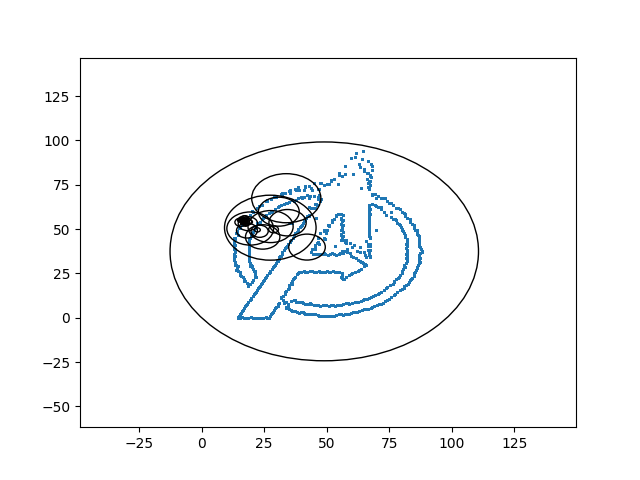

In [68]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
fig = plt.figure()
m=200
dist,pt = Makecirc(CoordList,m,0)
dist=np.max(np.asarray(dist)[:,1])
ax = plt.axes(xlim=(np.min(new_cities_order[:,0])-dist,np.max(new_cities_order[:,0])+dist), ylim=(np.min(new_cities_order[:,1])-dist, np.max(new_cities_order[:,1])+dist))
LV=Genlist(m)
Circles = [plt.Circle((0.0,0.0),0.0,fill=False,clip_on=False) for _ in xrange(len(LV))]
for circ in Circles:
    ax.add_artist(circ)
x,y=[],[]
sp = ax.scatter(x,y,s=1.0)
N_frames=720
def init():
    dist,pt = Makecirc(CoordList,m,0)
    for j in xrange(len(Circles)):
        Circles[j].set_radius(dist[j][1])
        Circles[j].center=dist[j][0]
    #sp.set_data(np.real(pt),np.imag(pt))
    x.append(np.real(pt))
    y.append(np.imag(pt))
    sp.set_offsets(np.c_[x,y])
    return Circles,sp
def animate(i):
    dist,pt = Makecirc(CoordList,m,i*2*np.pi/N_frames)
    for j in xrange(len(Circles)):
        Circles[j].set_radius(dist[j][1])
        Circles[j].center=dist[j][0]
    x.append(np.real(pt))
    y.append(np.imag(pt))
    sp.set_offsets(np.c_[x,y])
    return Circles,sp
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=N_frames, interval=5, blit=True)
#anim.save('Thanos.gif',writer='imagemagick',fps=30)
anim.save('AvengersLogo_'+str(m)+'_components.mp4', writer=writer)
plt.show()